<a href="https://colab.research.google.com/github/clairehhw/lectureCode-sp19/blob/master/Data%20Digitalization%20Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import sklearn
from io import StringIO
import os
import sys, getopt
from sklearn.feature_extraction.text import TfidfVectorizer
!pip install PyPDF3
from PyPDF3 import PdfFileReader
import re
import string
import numpy as np

     |████████████████████████████████| 71kB 2.2MB/s 
  Created wheel for PyPDF3: filename=PyPDF3-1.0.1-cp36-none-any.whl size=61615 sha256=96d139765f3d7cee7416f7da8d204ab22c3a12011e10fcf0cad72a041db60088
  Stored in directory: /root/.cache/pip/wheels/96/b4/cb/39888a3c5c7986f06cf15e2fe5d804a2735c7b3962e9f3d736
Successfully built PyPDF3


In [2]:
# get google drive access
!pip install --upgrade -q gspread
!pip install gspread-dataframe
import gspread
from gspread_dataframe import get_as_dataframe, set_with_dataframe
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
gc = gspread.authorize(GoogleCredentials.get_application_default())

# Construct The Reports Dataframe 

## Load Dataframe

In [0]:
# Load the Dataset, call it reports
sheet1 = gc.open_by_url("https://docs.google.com/spreadsheets/d/1OtCqsi6B0jJVOaMZfcgy7HHCHvq1PjBEiTjwCo5fPvk/edit#gid=0")
ws = sheet1.worksheet("Sheet1")
reports = get_as_dataframe(ws)
reports = reports[['File_Name',"State", "Page_Index", "Report Type","Category"]].dropna()


In [0]:
# Replace invalid values 
page = 3
for i in range(161, 175):
  reports.at[i, 'Page_Index'] = page
  page += 1

In [5]:
# Check valid
reports.Page_Index.values

array([67, 42, 44, 45, 46, 65, 68, 128, 49, 50, 51, 52, 53, 54, 29, 51,
       59, 60, 61, 61, 64, 65, 66, 73, 34, 26, 1, 19, 20, 21, 23, 26, 28,
       29, 30, 39, 37, 25, 26, 27, 28, 36, 34, 35, 23, 21, 17, 18, 19, 44,
       31, 32, 33, 34, 28, 29, 27, 21, 22, 23, 32, 22, 23, 24, 25, 31, 29,
       30, 20, 18, 15, 16, 17, 22, 19, 20, 21, 16, 17, 15, 13, 14, 35, 23,
       24, 25, 26, 34, 32, 33, 21, 19, 15, 16, 17, 36, 24, 25, 26, 27, 35,
       33, 34, 22, 20, 16, 17, 18, 37, 25, 26, 27, 28, 36, 34, 35, 23, 21,
       17, 18, 19, 22, 19, 20, 21, 17, 15, 13, 14, 31, 22, 23, 24, 25, 30,
       20, 18, 15, 16, 17, 36, 24, 25, 26, 27, 35, 33, 34, 22, 20, 16, 17,
       18, 5, 8, 28, 29, 30, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14,
       15, 16, 4, 5, 28, 29, 30, 31, 71, 72, 1, 2, 3, 4, 1, 2, 23, 16, 26,
       27, 28, 16, 53, 15, 22, 25, 26, 27, 52, 55, 133, 140, 136, 143, 51,
       52, 53, 12, 25, 34, 36, 37, 40, 48, 56, 13, 25, 31, 32, 36, 48, 13,
       26, 38, 39, 40, 45, 53, 

In [6]:
reports['File_Name'] = reports['File_Name'].astype(str)
reports['Page_Index'] = reports['Page_Index'].astype(int)
reports.head()

,File_Name,State,Page_Index,Report Type,Category
0,8435_FY_2017.pdf,TX,67,Govt Financial Report,Operating Revenues and Expenses by Fund
1,8435_FY_2017.pdf,TX,42,Govt Financial Report,Depreciation Details
2,7129_FY_2008.pdf,TX,44,Govt Financial Report,Operating Revenues and Expenses by Fund
3,7129_FY_2008.pdf,TX,45,Govt Financial Report,Statement of Cash Flow by Fund
4,7129_FY_2008.pdf,TX,46,Govt Financial Report,Statement of Cash Flow by Fund


## Fix Typos

In [0]:
#Fix "3329_2017" typo
reports['File_Name'] = reports['File_Name'].str.replace('3329_2017 Detail Budget Report (with 2015 actuals)', '3329_2017 Detail Budget Report (with 2016 actuals)', regex = False)

#Fix "2135_2011" typo
reports['File_Name'] = reports['File_Name'].str.replace('2135_2011_and_2013', '2135_2011_and_2012', regex = False)
reports['File_Name'] = reports['File_Name'].str.replace('2135_2011_and_2014', '2135_2011_and_2012', regex = False)

#Fix "3732_2006" typo
reports['File_Name'] = reports['File_Name'].str.replace('3732_2006-2009', '3732_2006-2008', regex = False)
reports['File_Name'] = reports['File_Name'].str.replace('3732_2006-2010', '3732_2006-2008', regex = False)

#Fix "5335_March 2016" typo
reports['File_Name'] = reports['File_Name'].str.replace('5335_March 2016', '5335_March 2015', regex = False)

#Add .pdf if necessary
for i, x in reports.iterrows():
    if x["File_Name"].endswith(".pdf") != True:
        reports["File_Name"][i] = str(x["File_Name"]) + ".pdf"

## Access files

In [8]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
reports['Path'] = [os.path.abspath('../%s/%s/%s/%s/%s/%s/%s/%s/%s' %('content', 'drive','My Drive', 'Work', 'Fall19', 'URAP', 'URAP_Data_Digitization','All_Muni_Docs_Searchable',row['State'])) for i, row in reports.iterrows()]

In [17]:
reports.head()

,File_Name,State,Page_Index,Report Type,Category,Path
0,8435_FY_2017.pdf,TX,67,Govt Financial Report,Operating Revenues and Expenses by Fund,/content/drive/My Drive/Work/Fall19/URAP/URAP_...
1,8435_FY_2017.pdf,TX,42,Govt Financial Report,Depreciation Details,/content/drive/My Drive/Work/Fall19/URAP/URAP_...
2,7129_FY_2008.pdf,TX,44,Govt Financial Report,Operating Revenues and Expenses by Fund,/content/drive/My Drive/Work/Fall19/URAP/URAP_...
3,7129_FY_2008.pdf,TX,45,Govt Financial Report,Statement of Cash Flow by Fund,/content/drive/My Drive/Work/Fall19/URAP/URAP_...
4,7129_FY_2008.pdf,TX,46,Govt Financial Report,Statement of Cash Flow by Fund,/content/drive/My Drive/Work/Fall19/URAP/URAP_...


In [0]:
#check if the ab_path really exists
for ab_path in reports['Path']:
    if os.path.exists(ab_path) != True:
        print(ab_path)   

In [19]:
display(reports)

,File_Name,State,Page_Index,Report Type,Category,Path
0,8435_FY_2017.pdf,TX,67,Govt Financial Report,Operating Revenues and Expenses by Fund,/content/drive/My Drive/Work/Fall19/URAP/URAP_...
1,8435_FY_2017.pdf,TX,42,Govt Financial Report,Depreciation Details,/content/drive/My Drive/Work/Fall19/URAP/URAP_...
2,7129_FY_2008.pdf,TX,44,Govt Financial Report,Operating Revenues and Expenses by Fund,/content/drive/My Drive/Work/Fall19/URAP/URAP_...
3,7129_FY_2008.pdf,TX,45,Govt Financial Report,Statement of Cash Flow by Fund,/content/drive/My Drive/Work/Fall19/URAP/URAP_...
4,7129_FY_2008.pdf,TX,46,Govt Financial Report,Statement of Cash Flow by Fund,/content/drive/My Drive/Work/Fall19/URAP/URAP_...
...,...,...,...,...,...,...
695,12473_2007.pdf,MA,28,Electric Only Report,Revenue by Class,/content/drive/My Drive/Work/Fall19/URAP/URAP_...
696,12473_2007.pdf,MA,26,Electric Only Report,In Lieu of Taxes,/content/drive/My Drive/Work/Fall19/URAP/URAP_...
697,12473_2007.pdf,MA,20,Electric Only Report,Cost of Utility Plant and Accumulated Deprecia...,/content/drive/My Drive/Work/Fall19/URAP/URAP_...
698,12473_2007.pdf,MA,21,Electric Only Report,Cost of Utility Plant and Accumulated Deprecia...,/content/drive/My Drive/Work/Fall19/URAP/URAP_...


In [0]:
# Define a function that extracts texts from a pdf file based on the filename and page number provided. 
def extract(fname, page):
    try:
        pdfFileObj = open(fname,'rb')
        pdfReader = PdfFileReader(pdfFileObj)
        pageObj = pdfReader.getPage(page-1)
        return pageObj.extractText()
    except:
        print(fname, page)

In [0]:
reports['Content'] = [extract(row['Path'] + '/' + row['File_Name'], row['Page_Index']) for i, row in reports.iterrows()]

# First Filter(Model) Construction

## Find Different Report Types

In [0]:
f1_reports = reports.copy()
f1_reports = f1_reports.rename({'Report Type': 'report_type'}, axis = 'columns')
f1_reports = f1_reports[pd.notnull(f1_reports['Content'])]
f1_reports['report_id'] = f1_reports['report_type'].factorize()[0]
f1_reports_id_df = f1_reports[['report_type', 'report_id']].drop_duplicates().sort_values('report_id')
f1_reports_to_id = dict(f1_reports_id_df.values)
id_to_f1_reports = dict(f1_reports_id_df[['report_id', 'report_type']].values)

In [53]:
f1_reports.head()

,File_Name,State,Page_Index,report_type,Category,Path,Content,report_id
0,8435_FY_2017.pdf,TX,67,Govt Financial Report,Operating Revenues and Expenses by Fund,/content/drive/My Drive/Work/Fall19/URAP/URAP_...,"City of Hempstead, Texas \nSchedule of Revenue...",0
1,8435_FY_2017.pdf,TX,42,Govt Financial Report,Depreciation Details,/content/drive/My Drive/Work/Fall19/URAP/URAP_...,"City of Hempstead, Texas \nNotes to the Financ...",0
2,7129_FY_2008.pdf,TX,44,Govt Financial Report,Operating Revenues and Expenses by Fund,/content/drive/My Drive/Work/Fall19/URAP/URAP_...,"CITY OF GEORGETOWN, TEXAS \nSTATEMENT OF REVEN...",0
3,7129_FY_2008.pdf,TX,45,Govt Financial Report,Statement of Cash Flow by Fund,/content/drive/My Drive/Work/Fall19/URAP/URAP_...,"CITY OF GEORGETOWN, TEXAS \nSTATEMENT OF CASH ...",0
4,7129_FY_2008.pdf,TX,46,Govt Financial Report,Statement of Cash Flow by Fund,/content/drive/My Drive/Work/Fall19/URAP/URAP_...,"CITY OF GEORGETOWN, TEXAS \nSTATEMENT OF CASH ...",0


## Preprocessing (Clean Up Texts)

In [0]:
f1_reports = f1_reports[['report_type', 'Content', 'report_id']]
import re 
import string
#Extract feature: number of rows
f1_reports['num_rows'] = f1_reports['Content'].str.count('\n')
f1_reports['Content'].replace(r'\s+|\\n', ' ', regex=True, inplace=True)
#Extract feature: number of numeric values
def num_numbers(text):
    temp = re.findall(r'\d+', text)
    return len(list(map(int, temp)))
f1_reports['num_numbers'] = f1_reports['Content'].apply(num_numbers)
f1_reports['Content'].replace(r'\d+', '', regex=True, inplace=True)
#Data cleaning: remove punctuations
def remove_punctuations(text):
    for punctuation in string.punctuation:
        text = text.replace(punctuation, '')
    return text
f1_reports['Content'] = f1_reports['Content'].apply(remove_punctuations)

## TF-IDF

In [55]:
# Convert texts to vectors
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
features = tfidf.fit_transform(reports.Content).toarray()
labels = f1_reports.report_type
features.shape

(693, 6790)

## Oversample Minorities

In [56]:
# Try SMOTE to oversample the reports.
from imblearn.over_sampling import SMOTE
sm = SMOTE(sampling_strategy='minority', random_state=7)
sm_X, sm_Y = sm.fit_sample(features ,labels)
sm_X.shape

(1188, 6790)

## Model Selection By Cross-Validation

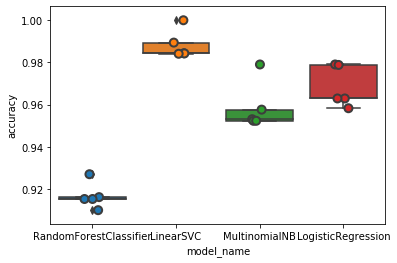

In [57]:
import warnings
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import MultinomialNB
import seaborn as sns
from sklearn.model_selection import train_test_split

## Split the data into training and testing data
sm_X_train_1, sm_X_test_1, sm_Y_train_1, sm_Y_test_1 = train_test_split(sm_X, sm_Y, test_size=0.2, random_state=47)

## Perform cross-validation only on the training data
warnings.simplefilter("ignore")
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, sm_X_train_1, sm_Y_train_1, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
    cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
    
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [58]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.988443
LogisticRegression        0.968431
MultinomialNB             0.958923
RandomForestClassifier    0.916811
Name: accuracy, dtype: float64

## Build filter_1 and test its performance

In [59]:
filter_1 = LinearSVC()
filter_1.fit(sm_X_train_1,sm_Y_train_1)
print(sklearn.metrics.classification_report(sm_Y_test_1, filter_1.predict(sm_X_test_1)))

                       precision    recall  f1-score   support

               Budget       1.00      1.00      1.00       104
 Electric Only Report       0.97      1.00      0.99       113
Govt Financial Report       1.00      0.86      0.92        21

             accuracy                           0.99       238
            macro avg       0.99      0.95      0.97       238
         weighted avg       0.99      0.99      0.99       238



# Build A Dataframe Of All Pages Of All Files

In [0]:
import os
root_path = "/content/drive/My Drive/Work/Fall19/URAP/URAP_Data_Digitization/All_Muni_Docs_Searchable"

List = []
for state in os.listdir(root_path):
    if str(state) == 'Code' or str(state) == '.DS_Store':
        continue
    else:
        state_dir = os.path.join(root_path, state)
        for filename in os.listdir(state_dir):
            file_path = os.path.join(state_dir, filename)
            try:
                pdf = PdfFileReader(open(file_path, 'rb'))
            except:
                print(filename)
                continue
            number_pages = pdf.getNumPages()
            for i in range(1, number_pages+1):
                dic = {'File_Name': filename, 'State':state,'Page_Index':i,'Path': file_path}
                List.append(dic)
all_pages = pd.DataFrame(List)

In [0]:
all_pages.head()

,File_Name,State,Page_Index,Path
0,122_FY_2005.pdf,NY,1,/content/drive/My Drive/Work/Fall19/URAP/URAP_...
1,122_FY_2005.pdf,NY,2,/content/drive/My Drive/Work/Fall19/URAP/URAP_...
2,122_FY_2005.pdf,NY,3,/content/drive/My Drive/Work/Fall19/URAP/URAP_...
3,122_FY_2005.pdf,NY,4,/content/drive/My Drive/Work/Fall19/URAP/URAP_...
4,122_FY_2005.pdf,NY,5,/content/drive/My Drive/Work/Fall19/URAP/URAP_...


# Category Classifier

## Create An Another Copy Of The Reports DataSet

In [0]:
f2_reports = reports.copy()
f2_reports['Category'] = f2_reports['Category'].astype(str)
f2_reports['label'] = f2_reports['Category'].factorize()[0]
category_counts = f2_reports['Category'].value_counts()
f2_reports['Content'] = [extract(row['Path'] + '/' + row['File_Name'], row['Page_Index']) for i, row in f2_reports.iterrows()]

In [0]:
f2_reports = f2_reports[f2_reports['Content'].isnull() == False]

In [0]:
# Clean up contents

f2_reports['Content'].replace(r'\d+', '', regex=True, inplace=True)
f2_reports['Content'] = f2_reports['Content'].apply(remove_punctuations)
f2_reports['Content'].replace(r'\s+|\\n', ' ', regex=True, inplace=True)
f2_reports['Content'] = f2_reports['Content'].str.lower()

In [0]:
# Set thresholds. If the frequency of a category is less then the threshold, it will be ignored. 
thresholds = np.array([1, 10, 20, 30, 40, 50])

#Set tfidf vector
tfidf = TfidfVectorizer(sublinear_tf=True, 
                        min_df=5, norm='l2', 
                        encoding='latin-1', 
                        ngram_range=(1, 2), 
                        stop_words='english')

SMOTE with threshold 1 failed


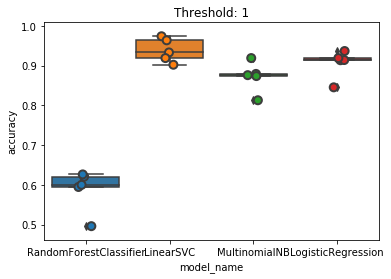

model_name
LinearSVC                 0.938613
LogisticRegression        0.905947
MultinomialNB             0.872315
RandomForestClassifier    0.587496
Name: accuracy, dtype: float64

SMOTE with threshold 10 succeeded


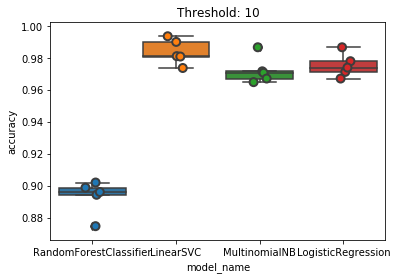

model_name
LinearSVC                 0.983755
LogisticRegression        0.975286
MultinomialNB             0.972085
RandomForestClassifier    0.893077
Name: accuracy, dtype: float64

SMOTE with threshold 20 succeeded


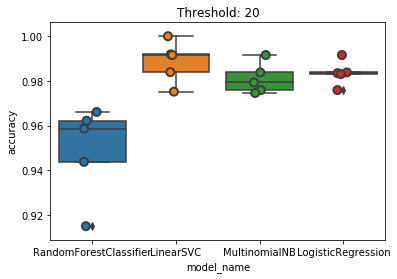

model_name
LinearSVC                 0.988528
LogisticRegression        0.983566
MultinomialNB             0.981044
RandomForestClassifier    0.949144
Name: accuracy, dtype: float64

SMOTE with threshold 30 succeeded


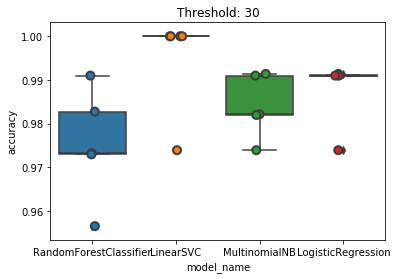

model_name
LinearSVC                 0.994783
LogisticRegression        0.987669
MultinomialNB             0.984082
RandomForestClassifier    0.975292
Name: accuracy, dtype: float64

SMOTE with threshold 40 succeeded


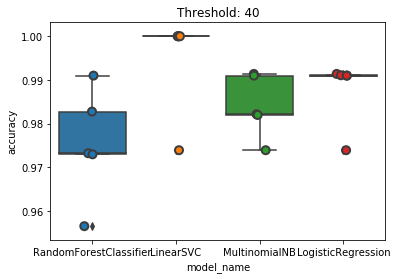

model_name
LinearSVC                 0.994783
LogisticRegression        0.987669
MultinomialNB             0.984082
RandomForestClassifier    0.975292
Name: accuracy, dtype: float64

SMOTE with threshold 50 succeeded


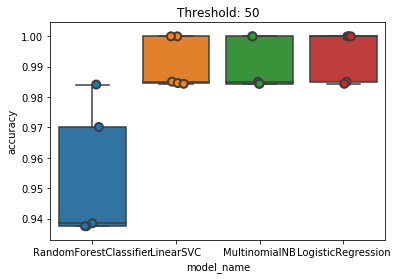

model_name
LinearSVC                 0.990813
LogisticRegression        0.993890
MultinomialNB             0.990765
RandomForestClassifier    0.953548
Name: accuracy, dtype: float64

In [60]:
# Iterate through each threshold and test the prediction accuracies.
for threshold in thresholds:
    
    # Only include the categories whose frequencies are above the threshold. Save them into a dataframe df.
    df = f2_reports[[(category_counts[category] >= threshold) for category in f2_reports['Category']]]
    features = tfidf.fit_transform(df['Content']).toarray()
    labels = df['label']
    warnings.simplefilter("ignore")
    
    # try to use SMOTE to oversample the reports if possible.
    try:
        sm = SMOTE(sampling_strategy='auto', random_state=7)
        sm_X, sm_Y = sm.fit_sample(features ,labels)
        print("SMOTE with threshold %s succeeded" %threshold )
    except:
        sm_X = features
        sm_Y = labels
        print("SMOTE with threshold %s failed" %threshold )
    
    ## Split the data into training and testing data
    sm_X_train_2, sm_X_test_2, sm_Y_train_2, sm_Y_test_2 = train_test_split(sm_X, sm_Y, test_size=0.2, random_state=47)
    # try RandomForest, LinearSVC, MultinomialNaiveBayes, and LogisticRegresssion.
    models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
    ]
    CV = 5
    cv_df = pd.DataFrame(index=range(CV * len(models)))
    entries = []
    for model in models:
        model_name = model.__class__.__name__
        accuracies = cross_val_score(model, sm_X_train_2, sm_Y_train_2, scoring='accuracy', cv=CV)
        for fold_idx, accuracy in enumerate(accuracies):
            entries.append((model_name, fold_idx, accuracy))
        cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
    
    #Plot the results
    sns.boxplot(x='model_name', y='accuracy', data=cv_df)
    sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
                  size=8, jitter=True, edgecolor="gray", linewidth=2).set_title('Threshold: %s' %(str(threshold)))
    plt.show()
    display(cv_df.groupby('model_name').accuracy.mean())

## So We Choose a LinearSVC Model With Threshold 30

In [61]:
## Build the second filter
filter_2 = LinearSVC()
df = f2_reports[[(category_counts[category] >= threshold) for category in f2_reports['Category']]]
features = tfidf.fit_transform(df.Content).toarray()
labels = df['label']
sm = SMOTE(sampling_strategy='auto', random_state=7)
sm_X, sm_Y = sm.fit_sample(features ,labels)
sm_X_train_2, sm_X_test_2, sm_Y_train_2, sm_Y_test_2 = train_test_split(sm_X, sm_Y, test_size=0.2, random_state=47)
filter_2.fit(sm_X_train_2,sm_Y_train_2)
display(sklearn.metrics.f1_score(sm_Y_test_2, filter_2.predict(sm_X_test_2), average='micro'))

0.9876543209876543

# Use Filter_1 And Filter_2 

In [63]:
from itertools import product
from sklearn.ensemble import VotingClassifier

# Training classifiers
clf_1 = LinearSVC()
clf_2 = LinearSVC()
eclf = VotingClassifier(estimators=[('f1_svc', clf_1), ('f2_svc', clf_2)],
                        voting='hard', weights=[2, 2])

clf1 = clf_1.fit(sm_X_train_1,sm_Y_train_1)
clf2 = clf_2.fit(sm_X_train_2,sm_Y_train_2)
eclf = eclf.fit(sm_X_train,sm_Y_train)

for clf, label in zip([clf1, clf2, eclf], ['Linear SVC f1', 'Linear SVC f2', 'Ensemble']):
  scores = cross_val_score(clf, sm_X_train, sm_Y_train, cv=5, scoring='accuracy')
  print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))


Accuracy: 0.99 (+/- 0.01) [Linear SVC f1]
Accuracy: 0.99 (+/- 0.01) [Linear SVC f2]
Accuracy: 0.99 (+/- 0.01) [Ensemble]
